
### Spectroscopic Data Analysis  

        Sean Keenan, PhD Physics  
        Quantum Memories Group, Heriot-Watt University, Edinburgh  
        2021  

In [1]:
%matplotlib widget
import spec_funcs as sf
import fit_funcs as ff
import numpy as np
import matplotlib.pyplot as mp
import os

mp.style.use('signature.mplstyle')


##### Set-up script  

        Select input folder and polarisation  

In [2]:
# folder containing all the requisite subfolders and data - refrences included
local = False
folder = r"0222_BB"
if local == True:
    path = os.path.join(r"C:\Users\sk88\Desktop", folder)
else:
    path = os.path.join(r"C:\Users\sk88\Dropbox (Heriot-Watt University Team)\RES_EPS_Quantum_Photonics_Lab\Experiments\Current Experiments\BB Telecom QM\2023_Pr_YVO_Sectroscopy\Visible\0.5%", folder)
# mark energies / wavelengths of interest
vis_forbid = ([16255, 17220], '--','red')
vis_sigma = ([16528], '-.', 'cyan')
vis_pi = ([16796], ':', 'olive')
vis = [vis_forbid, vis_sigma, vis_pi]

hotlines_sigma = ([16174, 16378, 16472, 16704, 16852], (0, (5, 10)), 'blue')
hotlines_pi = ([16444, 17163, 17140, 17034, 16606], (0, (3, 10, 1, 10)), 'green')
hotlines = [hotlines_pi, hotlines_sigma]

vis_woi = [vis_forbid, vis_sigma, vis_pi, hotlines_pi, hotlines_sigma]
# calibrate wavelength of OSA
calibration = 1.054269203603
# reference power correction
correction = 345/50
# reference names
refs = ("ref", "reference", "R")
# file extension types
exts = ('.csv', '.txt', '.CSV')
exceptions = ("notes", "setup", "ignore", "Thermal OD")
labels = 'wavenumber (cm${^{-1}}$)', 'OD'


##### Import Raw Spectroscopy Data
        Load raw data from csv file (delimiter is not a problem) and sort into groups - polarisations -> reference / spectrum


In [3]:
folder_list, file_list = sf.dir_interogate(path, exts, exceptions)
path_names = sf.read_files(folder_list, file_list)
selected_files = [sf.search_paths(paths, keys=refs) for paths in path_names]
ref_path_list = [column[0] for column in selected_files if column[0]]
data_path_list = [column[1] for column in selected_files if column[1]]
ref_paths = [value for sublist in ref_path_list for value in sublist]
data_paths = [value for sublist in data_path_list for value in sublist]
polarisations = sf.find_numbers(ref_paths, tail=1)
ref_locations = [os.path.join(path, x) for x in ref_paths]
data_locations = [os.path.join(path, x) for x in data_paths]
ref_data, ref_metadata = sf.data_extract(ref_locations, polarisations) 
data, metadata = sf.data_extract(data_locations, polarisations)


##### Main calculations

        Correct OD for background
        Create two data sets - corrected and subtracted 

In [4]:
wave_sets, od_sets = sf.OD_calc(ref_data, data, correction=True, c_factor=correction)
shifted_sets = sf.data_shift(wave_sets, calibration)
wavenumber_sets = [[[1E7 / x for x in wavelengths] for wavelengths in shifted_set] for shifted_set in shifted_sets]
backgrounds = [[sf.bin_data(od, 10) for od in od_set] for od_set in od_sets]
od_corrected = [[[x - mean_value for x in od] for od, mean_value in zip(od_set, background)] for od_set, background in zip(od_sets, backgrounds)]
od_ground = [od_corrected[i][0] for i in range(len(od_corrected))]
wave_ground = [wavenumber_sets[i][0] for i in range(len(wavenumber_sets))]
od_subtracted = [[[x-y for x, y in zip(excited, ground)] for excited in od_corrected[i]] for i, ground in enumerate(od_ground)]
minimums = [[min(od_sub) for od_sub in od_sub_set] for od_sub_set in od_subtracted]
od_subtracted =  [[[x - minimum for x in od_sub] for od_sub, minimum in zip(od_sub_set, minimum)] for od_sub_set, minimum in zip(od_subtracted, minimums)]


##### Find Peaks and Energies

        Calculate frequencies, wavenumbers and wavelengths of peaks

In [5]:
corrected_peaks = sf.peak_find(shifted_sets, od_corrected, prom_tol=None, top_tol=0.1, lims=None)
sub_peaks = sf.peak_find(shifted_sets, od_subtracted, prom_tol=None, top_tol=0.01, lims=None)
od_frequencies = sf.peak_freq(od_corrected, shifted_sets, lims=[1500, 1650])
od_wavenumbers = [[[sf.converter(frequency, d_type=1, c_type=0) for frequency in frequency_set] for frequency_set in frequency_list] for frequency_list in od_frequencies]
od_wavelengths = [[[sf.converter(frequency, d_type=1, c_type=2) for frequency in frequency_set] for frequency_set in frequency_list] for frequency_list in od_frequencies]
sub_frequencies = sf.peak_freq(sub_peaks, wave_sets, lims=[1500, 1650])
sub_wavenumbers = [[[sf.converter(frequency, d_type=1, c_type=0) for frequency in frequency_set] for frequency_set in frequency_list] for frequency_list in sub_frequencies]
sub_wavelengths = [[[sf.converter(frequency, d_type=1, c_type=2) for frequency in frequency_set] for frequency_set in frequency_list] for frequency_list in sub_frequencies]

c:\Users\sk88\Documents\Python\Spectroscopy\spec_funcs.py:702: RuntimeWarning: divide by zero encountered in divide
  (lambda x: 1e7/x, lambda x: 1e7/x))


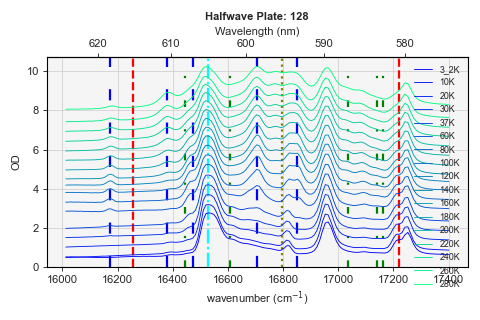

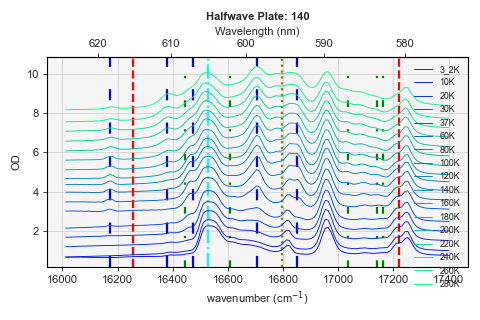

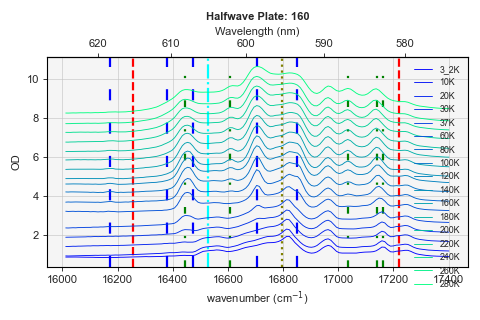

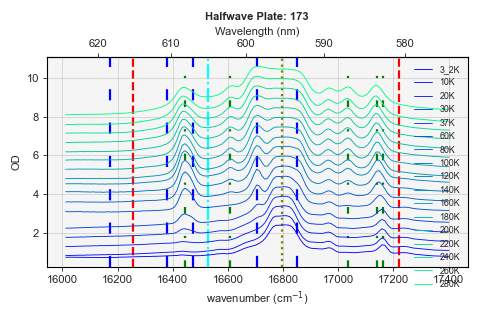

In [6]:
sf.plotter(wavenumber_sets, od_corrected, keys=polarisations, axis_lbls=labels, lims=(17400, 16000), shifter=0.5, woi=vis_woi, save=False, data_labels=folder_list)

In [7]:
sigma_sets = [set for set in od_corrected[0]]
sigma_x = [set for set in wavenumber_sets[0]]
pi_sets = [set for set in od_corrected[3]]
pi_x = [set for set in wavenumber_sets[3]]

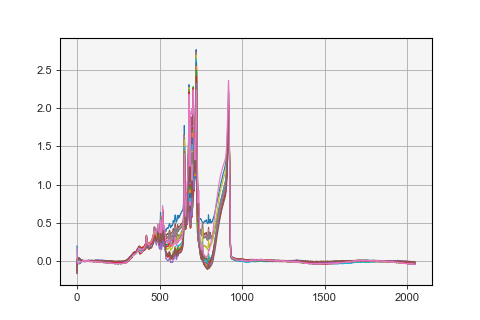

In [8]:
fig, ax = mp.subplots()

for set in sigma_sets:
    ax.plot(set)

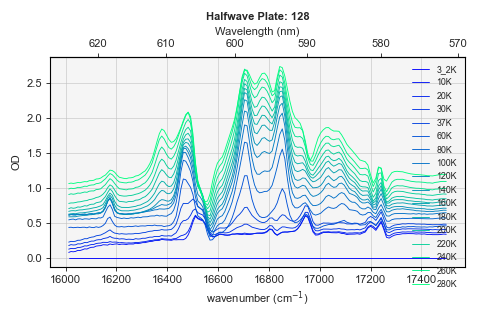

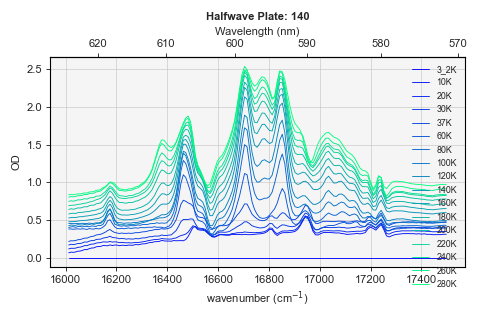

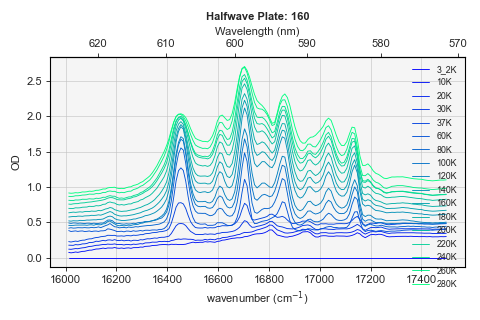

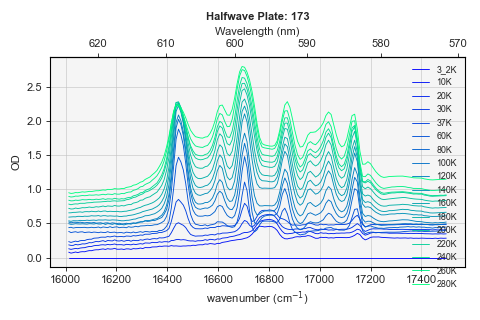

In [9]:
sf.plotter(wavenumber_sets, od_subtracted, keys=polarisations, axis_lbls=labels, shifter=0.05, lims=(17500, 16000), woi=(), save=False, data_labels=folder_list)


##### Plot Specific Data

        Plot 3K data for each polarisation
        Plot specific temperature spectra 

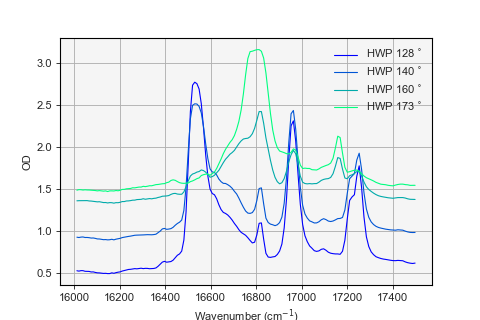

In [10]:
shifter = 0.25
shift= 0
colour = mp.cm.winter(np.linspace(0, 1, len(wave_ground)))
fig, ax = mp.subplots()
for n, wave in enumerate(wave_ground):
    lower, upper = sf.zoom(wave, bounds=(17500, 16000))
    x = np.array(wave)
    y = np.array([value + shift for value in od_ground[n]])
    ax.plot(x[lower:upper], y[lower:upper], color = colour[n], label= 'HWP ' + polarisations[n] + ' $^{\circ}$')
    ax.set_xlabel('Wavenumber (cm$^{-1}$)')
    ax.set_ylabel('OD')
    ax.legend()
    shift += shifter

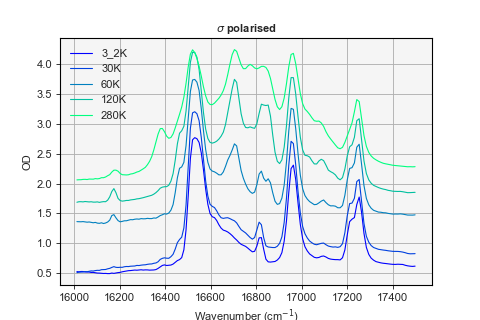

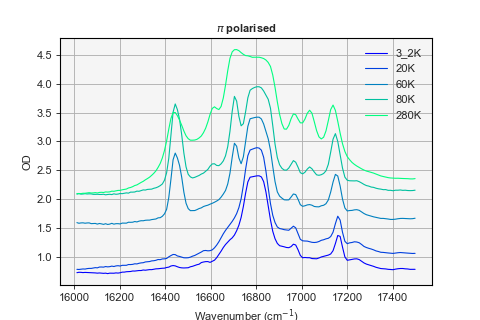

In [11]:
sigma_indexes = [0, 3, 5, 8, 16]
pi_indexes = [0, 2, 5, 6, 16]

shifter = 0.5
shift= 0
colour = mp.cm.winter(np.linspace(0, 1, len(sigma_indexes)))
fig_1, ax_1 = mp.subplots()
for index, n in enumerate(sigma_indexes):
    lower, upper = sf.zoom(wavenumber_sets[0][n], bounds=(17500, 16000))
    x = np.array(wavenumber_sets[0][n])
    y = np.array([value + shift for value in od_corrected[0][n]])
    ax_1.plot(x[lower:upper], y[lower:upper], color=colour[index], label=folder_list[n])
    ax_1.set_title('$\sigma$ polarised')
    ax_1.set_xlabel('Wavenumber (cm$^{-1}$)')
    ax_1.set_ylabel('OD')
    ax_1.legend()
    shift += shifter

shifter = 0.5
shift= 0
colour = mp.cm.winter(np.linspace(0, 1, len(pi_indexes)))
fig_2, ax_2 = mp.subplots()
for index, n in enumerate(pi_indexes):
    lower, upper = sf.zoom(wavenumber_sets[0][0], bounds=(17500, 16000))
    x = np.array(wavenumber_sets[-1][0])
    y = np.array([value + shift for value in od_corrected[-1][n]])
    ax_2.plot(x[lower:upper], y[lower:upper], color = colour[index], label=os.path.split(folder_list[n])[1])
    ax_2.set_title('$\pi$ polarised')
    ax_2.set_xlabel('Wavenumber (cm$^{-1}$)')
    ax_2.set_ylabel('OD')
    ax_2.legend()
    shift += shifter

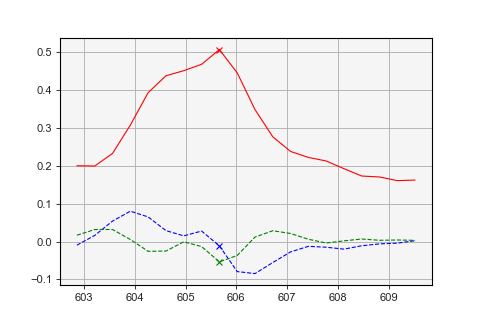

In [12]:
from scipy.signal import find_peaks, argrelmax, argrelmin

low, high = sf.zoom(shifted_sets[0][2], (603, 610))
test_x = np.array(shifted_sets[0][2])
test_y = np.array(od_subtracted[0][2])
grad_y = np.gradient(test_y)
grad_2y = np.gradient(grad_y)
a = argrelmax(test_y)
b = a[0].tolist()
c = [x for x in b if x >= low and x <= high]
fig, ax = mp.subplots()
ax.plot(test_x[low:high], test_y[low:high], 'r')
ax.plot(test_x[c], test_y[c], 'xr')
ax.plot(test_x[low:high], grad_y[low:high], '--b')
ax.plot(test_x[c], grad_y[c], 'xb')
ax.plot(test_x[low:high], grad_2y[low:high], '--g')
ax.plot(test_x[c], grad_2y[c], 'xg')

In [13]:
low_128, high_128 = sf.zoom(shifted_sets[0][0], bounds=(605, 620))
low_173, high_173 = sf.zoom(shifted_sets[0][0], bounds=(596, 610))
peak_sub_128 = [[sf.find_OD(y_values=od, peaks=peaks, lims=(low_128, high_128)) for od, peaks in zip(od_set, peak_set)] for od_set, peak_set in zip(od_subtracted, sub_peaks)]
peak_sub_173 = [[sf.find_OD(y_values=od, peaks=peaks, lims=(low_173, high_173)) for od, peaks in zip(od_set, peak_set)] for od_set, peak_set in zip(od_subtracted, sub_peaks)]

In [14]:
low_128, high_128 = sf.zoom(shifted_sets[0][0], bounds=(603, 607))
low_173, high_173 = sf.zoom(shifted_sets[0][0], bounds=(594, 597))
peak_cor_128 = [[sf.find_OD(y_values=od, peaks=peaks, lims=(low_128, high_128)) for od, peaks in zip(od_set, peak_set)] for od_set, peak_set in zip(od_corrected, corrected_peaks)]
peak_cor_173 = [[sf.find_OD(y_values=od, peaks=peaks, lims=(low_173, high_173)) for od, peaks in zip(od_set, peak_set)] for od_set, peak_set in zip(od_corrected, corrected_peaks)]

[16529.86934854778, 16529.86934854778, 16529.86934854778, 16529.86934854778, 16529.86934854778, 16529.86934854778, 16529.86934854778, 16529.86934854778, 16520.298867578997, 16520.298867578997, 16520.298867578997, 16520.298867578997, 16520.298867578997, 16520.298867578997, 16520.298867578997, 16520.298867578997, 16520.298867578997]


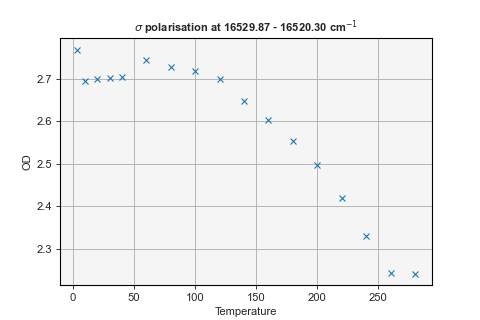

In [15]:
peak_0 = [value for values in peak_cor_128[0] for value in values]
od_frequencies123 = sf.peak_freq(corrected_peaks, shifted_sets, lims=[603,607])
freq_0 = [frequency for frequencies in od_frequencies123[0] for frequency in frequencies]
wavenumber_0 = [sf.converter(freq, 1, 0) for freq in freq_0]
print(wavenumber_0)

temp_0 = [3.2, 10, 20, 30, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280]
fig_1, ax_1 = mp.subplots()
ax_1.set_title('$\sigma$ polarisation at 16529.87 - 16520.30 cm$^{-1}$')
ax_1.set(xlabel='Temperature', ylabel='OD')
ax_1.plot(temp_0, peak_0, 'x')

[16453.645398662877, 16378.191178376526, 16406.397032077566, 16463.13106310214, 16463.13106310214, 16463.13106310214, 16463.13106310214, 16472.628776641577, 16472.628776641577, 16472.628776641577, 16378.191178376526, 16378.191178376526, 16378.191178376526, 16378.191178376526, 16378.191178376526, 16378.191178376526]


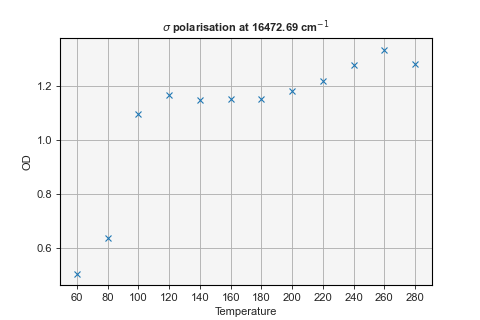

In [16]:
peak_2 = [peak_sub_128[0][i][0] for i in range(len(peak_sub_128[0])) if i != 0]
sub_frequencies = sf.peak_freq(sub_peaks, shifted_sets, lims=[607,620])
freq_2 = [sub_frequencies[0][i][0] for i in range(len(sub_frequencies[0])) if i != 0]
wavenumber_2 = [sf.converter(freq, d_type=1, c_type=0) for freq in freq_2]
print(wavenumber_2)

temp_2 = [60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280]
peak_2.pop(0)
peak_2.pop(1)
peak_2.pop(2)
peak_2.pop(3)
fig_1, ax_1 = mp.subplots()
ax_1.set_title('$\sigma$ polarisation at 16472.69 cm$^{-1}$')
ax_1.set_xticks(temp_2)
ax_1.set(xlabel='Temperature', ylabel='OD')
ax_1.plot(temp_2, peak_2, 'x')

[16174.569320542438, 16174.569320542438, 16220.355283312414, 16220.355283312414, 16220.355283312414, 16174.569320542438, 16247.964515897065, 16174.569320542438, 16378.191178376526, 16229.54684761553, 16378.191178376526, 16378.191178376526, 16378.191178376526, 16378.191178376526, 16378.191178376526, 16378.191178376526]


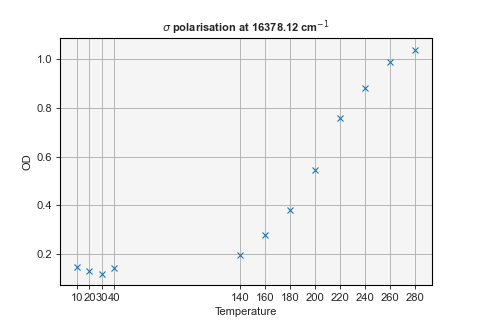

In [17]:
peak_3 = [peak_sub_128[0][i][-2] for i in range(len(peak_sub_128[0])) if i != 0]
sub_frequencies = sf.peak_freq(sub_peaks,shifted_sets, lims=[605,620])
freq_3 = [sub_frequencies[0][i][-2] for i in range(len(sub_frequencies[0])) if i != 0]
wavenumber_3 = [sf.converter(freq, d_type=1, c_type=0) for freq in freq_3]
print(wavenumber_3)
temp_3 = [10, 20, 30, 40, 140, 160, 180, 200, 220, 240, 260, 280]
peak_3.pop(0)
peak_3.pop(4)
peak_3.pop(5)
peak_3.pop(6)
peak_3.pop(7)
peak_3.insert(0, peak_sub_128[0][1][-3])
fig_2, ax_2 = mp.subplots()
ax_2.set_title('$\sigma$ polarisation at 16378.12 cm$^{-1}$')
ax_2.set(xlabel='Temperature', ylabel='OD')
ax_2.set_xticks(temp_3)
ax_2.plot(temp_3, peak_3, 'x')

[16147.234479268576, 16147.234479268576, 16174.569320542438, 16174.569320542438, 16174.569320542438, 16129.067880067747, 16174.569320542438, 16129.067880067747, 16174.569320542438, 16174.569320542438, 16174.569320542438, 16174.569320542438, 16174.569320542438, 16174.569320542438, 16174.569320542438, 16174.569320542438]


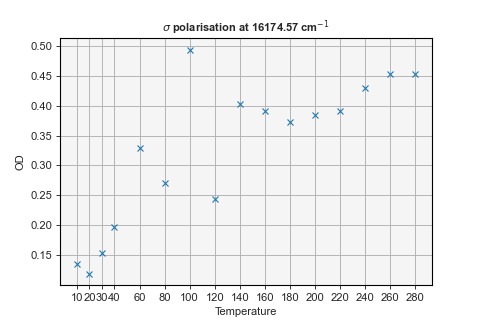

In [18]:
peak_4 = [peak_sub_128[0][i][-1] for i in range(len(peak_sub_128[0])) if i != 0]
sub_frequencies = sf.peak_freq(sub_peaks, shifted_sets, lims=[605,620])
freq_4 = [sub_frequencies[0][i][-1] for i in range(len(sub_frequencies[0])) if i != 0]
wavenumber_4 = [sf.converter(freq, d_type=1, c_type=0) for freq in freq_4]
print(wavenumber_4)
temp_4 = [10, 20, 30, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280]
fig_3, ax_3 = mp.subplots()
ax_3.set_title('$\sigma$ polarisation at 16174.57 cm$^{-1}$')
ax_3.set(xlabel='Temperature', ylabel='OD')
ax_3.set_xticks(temp_4)
ax_3.plot(temp_4, peak_4, 'x')

[16812.81767035043, 16802.88370304036, 16773.15891316879, 16802.88370304036, 16802.88370304036, 16802.88370304036, 16802.88370304036, 16802.88370304036, 16812.81767035043, 16802.88370304036, 16812.81767035043, 16792.96260401149, 16802.88370304036, 16773.15891316879, 16802.88370304036, 16773.15891316879, 16802.88370304036, 16773.15891316879, 16792.96260401149, 16773.15891316879, 16802.88370304036, 16773.15891316879, 16802.88370304036]


ValueError: x and y must have same first dimension, but have shapes (15,) and (23,)

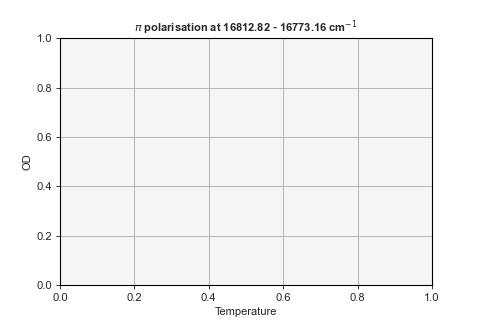

In [19]:
peak173_0 = [value for values in peak_cor_173[3] for value in values]
od_frequencies173 = sf.peak_freq(corrected_peaks, shifted_sets, lims=[590,598])
freq173_0 = [frequency for frequencies in od_frequencies173[3] for frequency in frequencies]
wavenumber173_0 = [sf.converter(freq, 1, 0) for freq in freq173_0]
print(wavenumber173_0)

temp173_0 = [3.2, 10, 20, 30, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240]
fig_0, ax_0 = mp.subplots()
ax_0.set_title('$\pi$ polarisation at 16812.82 - 16773.16 cm$^{-1}$')
ax_0.set(xlabel='Temperature', ylabel='OD')
ax_0.plot(temp173_0, peak173_0, 'xr')

In [ ]:
peak173_2 = [peak_sub_173[3][i][0] for i in range(len(peak_sub_173[0])) if i != 0]
sub_frequencies = sf.peak_freq(sub_peaks, shifted_sets, lims=[597,610])
freq173_2 = [sub_frequencies[3][i][0] for i in range(len(sub_frequencies[3])) if i != 0]
wavenumber173_2 = [sf.converter(freq, d_type=1, c_type=0) for freq in freq173_2]
print(wavenumber173_2)
peak173_2.pop(0)
peak173_2.pop(1)
temp173_2 = [30, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280]

fig_4, ax_4 = mp.subplots()
ax_4.set_title('$\pi$ polarisation at 16704.25 cm$^{-1}$')
ax_4.set(xlabel='Temperature', ylabel='OD')
ax_4.set_xticks(temp173_2)
ax_4.plot(temp173_2, peak173_2, 'xr')


In [ ]:
peak173_3 = [peak_sub_173[3][i][1] for i in range(len(peak_sub_173[0])) if i != 0]
sub_frequencies = sf.peak_freq(sub_peaks, shifted_sets, lims=[597,610])
freq173_3 = [sub_frequencies[3][i][1] for i in range(len(sub_frequencies[3])) if i != 0]
wavenumber173_3 = [sf.converter(freq, d_type=1, c_type=0) for freq in freq173_3]
print(wavenumber173_3)
peak173_3.pop(0)
peak173_3.pop(1)
peak173_3.pop(2)
peak173_3.pop(3)
temp173_3 = [60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280]

fig_5, ax_5 = mp.subplots()
ax_5.set_title('$\pi$ polarisation at 16606.87 cm$^{-1}$')
ax_5.set(xlabel='Temperature', ylabel='OD')
ax_5.set_xticks(temp173_3)
ax_5.plot(temp173_3, peak173_3, 'xr')

In [ ]:
peak173_4 = [peak_sub_173[3][i][-1] for i in range(len(peak_sub_173[0])) if i != 0]
sub_frequencies = sf.peak_freq(sub_peaks, shifted_sets, lims=[597,610])
freq173_4 = [sub_frequencies[3][i][-1] for i in range(len(sub_frequencies[0])) if i != 0]
wavenumber173_4 = [sf.converter(freq, d_type=1, c_type=0) for freq in freq173_4]
print(wavenumber173_3)
peak173_4.pop(0)

temp173_4 = [20, 30, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280]

fig_6, ax_6 = mp.subplots()
ax_6.set_title('$\pi$ polarisation at 16444.17 cm$^{-1}$')
ax_6.set(xlabel='Temperature', ylabel='OD')
ax_6.set_xticks(temp173_4)
ax_6.plot(temp173_4, peak173_4, 'xr')

3P0 

In [ ]:
import matplotlib.pyplot as mp
temp = [3.2, 10, 20, 30, 40, 50, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280]
count = -1

fig_1, ax_1 = mp.subplots()
fig_2, ax_2 = mp.subplots()
fig_3, ax_3 = mp.subplots()

ax_1.set(xlabel='Temperature', ylabel='OD')
ax_2.set(xlabel='Temperature', ylabel='OD')
ax_3.set(xlabel='Temperature', ylabel='OD')

for index_1, OD_list in enumerate(peak_sub_128[0]):
    for index_2, value in enumerate(OD_list):
        if index_2 == 0:
            ax_1.plot(temp[index_1], value, 'xb')
        if index_1 > 9 and index_2 == 1:
            ax_2.plot(temp[index_1], value, 'xr')
        if index_2 == 2 or index_1 < 10 and index_2 == 2:
            ax_3.plot(temp[index_1], value, 'xg')


In [ ]:
import matplotlib.pyplot as mp
temp = [3.2, 10, 20, 30, 40, 50, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280]

fig_1, ax_1 = mp.subplots()
fig_2, ax_2 = mp.subplots()
fig_3, ax_3 = mp.subplots()

ax_1.set(xlabel='Temperature', ylabel='OD')
ax_2.set(xlabel='Temperature', ylabel='OD')
ax_3.set(xlabel='Temperature', ylabel='OD')

for index_1, OD_list in enumerate(peak_OD_173[3]):
    for index_2, value in enumerate(OD_list):
        if index_2 == 0:
            ax_1.plot(temp[index_1], value, 'xb')
        if index_2 == 1:
            ax_2.plot(temp[index_1], value, 'xr')
        if index_2 == 2:
            ax_3.plot(temp[index_1], value, 'xg')


In [ ]:
import fit_funcs as ff
import numpy as np
import matplotlib.pyplot as mp
from scipy.optimize import leastsq

x = np.linspace(0, 100, 100)
param_1 = [1, 5, 80, 8]
param_2 = [1, 0, 20, 5]
param_3 = [1, -2, 60, 5]
param_4 = [2, 0, 30, 10]

fit_param_1 = [1, 5, 70, 20]
fit_param_2 = [1, 0, 20, 20]
fit_param_3 = [1, -2, 60, 10]
fit_param_4 = [1, 0, 20, 20]
param = param_1 + param_2 + param_3 + param_4
fit_param = fit_param_1 + fit_param_2 + fit_param_3 + fit_param_4
y = ff.N_gaussian(x, *param)

fit, err = ff.fitNgauss(x, y, params=fit_param)

mp.plot(x, y)
mp.plot(x, ff.N_gaussian(x, *fit), 'x')
mp.show()